In [ ]:
!pip install numpy matplotlib librosa scipy plotly nbformat

In [56]:
import numpy as np
from scipy.io import wavfile
from IPython.display import Audio, display
import plotly.graph_objects as go

# ============================================================================
# SECTION 1: SIGNAL GENERATION (The Physics)
# ============================================================================
# Why: Create synthetic audio signals to learn DSP fundamentals.
# What we'll build: Two pure tones at different frequencies + noise
#
# Real-world analogy: Imagine a room with a low hum (e.g., AC power at 150 Hz)
# and a bird chirping (high-pitched at 3000 Hz). We'll simulate this.
# ============================================================================

# --- Setup: Key audio parameters ---
sample_rate = 16000  # Hz (samples per second). Standard for speech/phone audio.
duration = 3  # seconds. How long is our recording?
amplitude = 0.5  # Max amplitude for our sine waves (range -1 to 1)

# --- Function: Pure sine wave generator ---
def generate_tone(freq, duration, sr=16000):
    """
    Create a pure sine wave at a given frequency.
    
    Math: y(t) = A * sin(2π*f*t)
    - A = 0.5 (Amplitude, controls loudness)
    - f = Frequency in Hz (e.g., 150 Hz = 150 cycles per second)
    - t = time array from 0 to duration
    
    Returns:
      t: time array (used for plotting)
      signal: the actual waveform (numpy array of audio samples)
    """
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    signal = amplitude * np.sin(2 * np.pi * freq * t) 
    return t, signal

# --- Create two component signals ---
t, tone_low = generate_tone(150, duration, sample_rate)  # Low tone (like AC hum)
_, tone_high = generate_tone(3000, duration, sample_rate)  # High tone (like birdsong)
audio = tone_low + tone_high  # Mix them together (linear superposition)

# --- Add realistic noise ---
# Why: Real recordings are never clean. Microphone noise, wind, etc.
noise = np.random.normal(0, 0.1, audio.shape)  # Gaussian noise: mean=0, std=0.1
noisy_audio = audio + noise  # Composite signal: tone_low + tone_high + noise

# --- Info & Playback ---
print(f"Signal Generated. shape: {noisy_audio.shape}, Sampling Rate: {sample_rate}")
print(f"  → {noisy_audio.shape[0]} samples at {sample_rate} Hz = {duration} seconds")
print(f"  → To reconstruct audio: play 16000 samples per second")

rms_manual = np.sqrt(np.mean(tone_high*2))
print(f"RMS Amplitude (Perceived Loudness): {rms_manual:.4f}")
print(f"  → Range typically 0–1 for normalized audio")
display(Audio(audio, rate=sample_rate, embed=True))

Signal Generated. shape: (48000,), Sampling Rate: 16000
  → 48000 samples at 16000 Hz = 3 seconds
  → To reconstruct audio: play 16000 samples per second
RMS Amplitude (Perceived Loudness): 0.0000
  → Range typically 0–1 for normalized audio


In [57]:
# Minimal, interactive time‑domain view of our signal components
# Why: See how the noisy composite waveform relates to its two tones.
# How: Use Plotly for hover/zoom/legend toggling with the least code.

import plotly.graph_objects as go  # Interactive plotting (already imported above in the notebook)

# 1) Pick a short time window so the plot is responsive and features are clear.
# At 16 kHz, 1000 samples ≈ 0.0625 seconds.
N = 1000

# 2) Build an interactive line plot with three traces:
#    - Noisy Signal: what you would "record" (tone_low + tone_high + noise)
#    - High Tone (3000 Hz): fast oscillations
#    - Underlying Low Tone (150 Hz): slow oscillations (dashed for contrast)
fig = go.Figure([
    go.Scatter(x=t[:N], y=noisy_audio[:N], name='Noisy Signal', opacity=0.7),
    go.Scatter(x=t[:N], y=tone_high[:N], name='High Tone (3000 Hz)', opacity=0.5),
    go.Scatter(x=t[:N], y=tone_low[:N], name='Low Tone (150 Hz)', line=dict(dash='dash'), opacity=0.9)
])

# 3) Tidy layout. Tip: Use the legend to hide/show components as you inspect.
fig.update_layout(
    title='Time Domain: Composite vs. Component Tones',
    xaxis_title='Time (s)',
    yaxis_title='Amplitude',
    width=1400,
    height=400,
    hovermode='x unified'  # One unified tooltip across traces at a given time
)

# Try this: Click a legend item to toggle visibility. Drag to zoom.
fig.show()

In [69]:
# ============================================================================
# SECTION 2: TIME DOMAIN ANALYSIS
# ============================================================================
# Why: Measure signal properties directly from time samples.
# Use case: RMS (Root Mean Square) is the "loudness" or energy metric.
# Definition: RMS is basically average amplitude over time without direction.
# Peak: measures the tallest wave in the wavform/highest amplitude.
# ============================================================================

# --- RMS Amplitude (Energy/Loudness Metric) ---
# Formula: RMS = sqrt( mean(x[n]^2) for all n )
# 
# Intuition:
#   1. Square each sample (x[n]^2) to get energy
#   2. Average the energy across all samples (mean)
#   3. Take the square root to get back to amplitude scale
#
# Why it matters:
#   - RMS is what our ears perceive as "loudness"
#   - Used in audio gain control, dynamic range, etc.
#   - In dB scale: dB = 20*log10(RMS/reference)

def rms(x):
    # Formula: RMS = sqrt( mean(x[n]^2) for all n )
    return np.sqrt(np.mean(x**2))

print("RMS tone_low             :", rms(tone_low))
print("RMS tone_high            :", rms(tone_high))
print(f"  → RMS of tone_high and tone_low remain ~ same since their amplitudes are same at {amplitude} irrespective of the number of oscillations.\n")
print("RMS Audio                :", rms(audio))
print("RMS Audio with Noise     :", rms(noisy_audio))
print("Peak Amplitude           :", np.max(np.abs(noisy_audio)))

print(f"  → Range typically 0–1 for normalized audio")

RMS tone_low             : 0.3535533905932738
RMS tone_high            : 0.3535533905932739
  → RMS of tone_high and tone_low remain ~ same since their amplitudes are same at 0.5 irrespective of the number of oscillations.

RMS Audio                : 0.49999999999999967
RMS Audio with Noise     : 0.5089686135066941
Peak Amplitude           : 1.27725536199845
  → Range typically 0–1 for normalized audio


np.float64(2.304486780111583e-08)

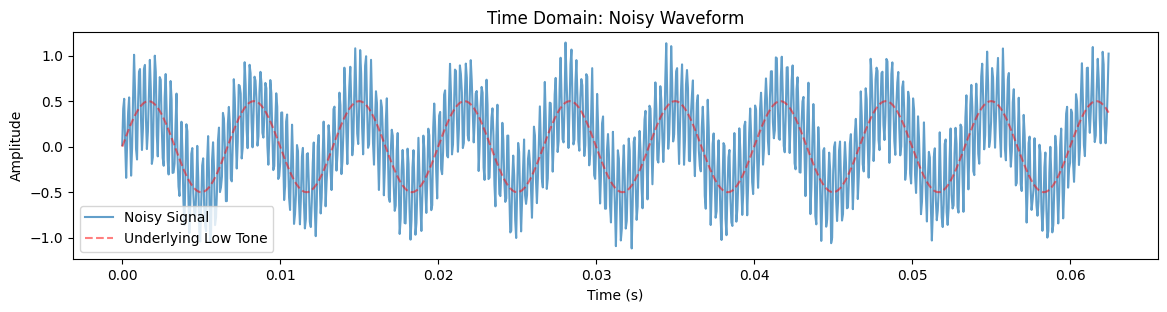

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display
from scipy.signal import spectrogram, butter, lfilter

# --- 1. SIGNAL GENERATION (The Physics) ---
def generate_tone(freq, duration, sr=16000):
    """Generates a pure sine wave."""
    t = np.linspace(0, duration, int(sr * duration), endpoint=False)
    # Math: A * sin(2 * pi * f * t)
    signal = 0.5 * np.sin(2 * np.pi * freq * t) 
    return t, signal

sr = 16000
duration = 1.0

# Create a complex signal: Low hum (150Hz) + High whistle (3000Hz)
t, tone_low = generate_tone(150, duration, sr)
_, tone_high = generate_tone(3000, duration, sr)
signal = tone_low + tone_high

# Add Random Noise (Simulating a real environment)
noise = np.random.normal(0, 0.1, signal.shape) # Mean 0, Std 0.1
noisy_signal = signal + noise

# print(f"Signal Generated. shape: {signal.shape}, Sampling Rate: {sr}")

# # --- 2. TIME DOMAIN MANIPULATION (Math in Code) ---

# # RMS Amplitude Calculation (Manual implementation)
# rms_manual = np.sqrt(np.mean(noisy_signal**2))
# print(f"RMS Amplitude (Loudness): {rms_manual:.4f}")

# # --- 3. FREQUENCY DOMAIN (FFT Intuition) ---

# # We will perform a real FFT
# # This converts our array of 16000 time samples -> 8001 frequency bins
# fft_spectrum = np.fft.rfft(noisy_signal)
# freqs = np.fft.rfftfreq(len(noisy_signal), 1/sr)
# magnitude = np.abs(fft_spectrum)

# --- 4. VISUALIZATION ---

plt.figure(figsize=(14, 10))

# Plot 1: The Waveform (Time Domain)
plt.subplot(3, 1, 1)
plt.title("Time Domain: Noisy Waveform")
plt.plot(t[:1000], noisy_signal[:1000], label='Noisy Signal', alpha=0.7)
plt.plot(t[:1000], tone_low[:1000], 'r--', label='Underlying Low Tone', alpha=0.5)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.legend()

# # Plot 2: The FFT (Frequency Domain)
# plt.subplot(3, 1, 2)
# plt.title("Frequency Domain: FFT Magnitude")
# plt.plot(freqs, magnitude)
# plt.xlabel("Frequency (Hz)")
# plt.ylabel("Magnitude")
# plt.xlim(0, 4000) # Zoom in to see our 150Hz and 3000Hz spikes
# plt.grid(True)
# plt.annotate('Low Tone (150Hz)', xy=(150, np.max(magnitude)/2), xytext=(500, np.max(magnitude)/2),
#              arrowprops=dict(facecolor='black', shrink=0.05))
# plt.annotate('High Tone (3000Hz)', xy=(3000, np.max(magnitude)/4), xytext=(2000, np.max(magnitude)/4),
#              arrowprops=dict(facecolor='black', shrink=0.05))

# # Plot 3: The Spectrogram (Mel Scale)
# # This is what AI sees. 
# plt.subplot(3, 1, 3)
# # Convert to Mel Spectrogram
# mel_spec = librosa.feature.melspectrogram(y=noisy_signal, sr=sr, n_mels=128, fmax=8000)
# # Convert to Log Scale (dB) - The way humans hear
# mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)

# librosa.display.specshow(mel_spec_db, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
# plt.colorbar(format='%+2.0f dB')
# plt.title("Mel Spectrogram (AI Input Feature)")

# plt.tight_layout()
# plt.show()

# # --- 5. SIMPLE "RESEARCH" MANIPULATION ---
# # Example: Band-pass filter (Cleaning)
# # We want to remove the 3000Hz noise and keep the 150Hz voice.

# def butter_lowpass(cutoff, fs, order=5):
#     nyq = 0.5 * fs
#     normal_cutoff = cutoff / nyq
#     b, a = butter(order, normal_cutoff, btype='low', analog=False)
#     return b, a

# def butter_lowpass_filter(data, cutoff, fs, order=5):
#     b, a = butter_lowpass(cutoff, fs, order=order)
#     y = lfilter(b, a, data)
#     return y

# # Filter everything above 1000Hz
# cleaner_signal = butter_lowpass_filter(noisy_signal, cutoff=1000, fs=sr, order=6)

# print(f"\nApplied Low-Pass Filter at 1000Hz.")
# print(f"Original RMS: {np.sqrt(np.mean(noisy_signal**2)):.4f}")
# print(f"Filtered RMS: {np.sqrt(np.mean(cleaner_signal**2)):.4f} (High freq energy removed)")